In [11]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import time 
#import nntools

Building visual intuitions for the what transformations are happening to the images

In [12]:
some_shape = (180, 240, 3)
some_size = some_shape[:2]
path = r"C:\Users\13463\OneDrive\Pictures\tumblr_0ea62a352230ab3d8e59de6e80a0c686_a45bb023_1280cropped.jpg"
image = cv2.imread(path)
other_shape = image.shape
other_size = other_shape[:2]
print(f"Image shape: {other_shape}")
print(f"Image size: {other_size}")
print(f"some_size: {some_size}")
i = np.random.randint(other_size[0] - some_size[0])
j = np.random.randint(other_size[1] - some_size[1])
print(f"Random indices: ({i}, {j})")



Image shape: (561, 1000, 3)
Image size: (561, 1000)
some_size: (180, 240)
Random indices: (326, 717)


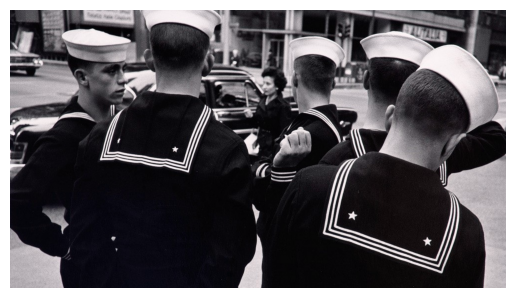

In [13]:
plt.imshow(image)
plt.axis('off')
plt.show()

torch.Size([3, 561, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


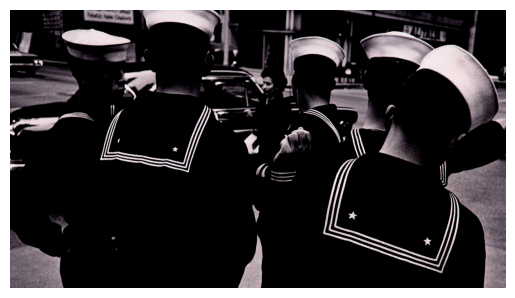

In [14]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
whole_new_image = transform(image)
#PyTorch tensor shape is (C, H, W) as opposed to (H, W, C) in OpenCV and numpy
print(whole_new_image.shape)
whole_new_image = whole_new_image.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(whole_new_image)
plt.axis('off')
plt.show()

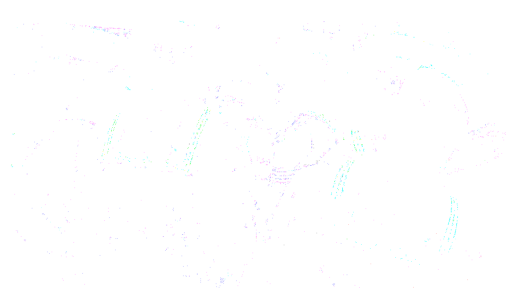

In [15]:
whole_new__image = np.moveaxis(whole_new_image, [0, 1, 2], [2, 0, 1])
image = (image + 1) / 2
image[image < 0] = 0
image[image > 1] = 1
plt.imshow(image)
plt.axis('off')
plt.show()

The transformations I made may make more sense on image stored as PIL Image rather than as a NumPy array(?)

In [16]:
dataset_root_dir = 'BSDS300/images'

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
class NoisyBSDSDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma = 30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return f"NoisyBSDSDataset(mode={self.mode}, image_size={self.image_size}, sigma={self.sigma})"
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')

        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])

        clean = clean.crop([i, j, i + self.image_size[0], j + self.image_size[1]])
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
        clean = transform(clean)

        noisy = clean + 2 / 255 * self.sigma * torch.randn_like(clean)

        return noisy, clean

In [19]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

### Build training set and testing set

In [20]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

Image size is torch.Size([3, 320, 320])


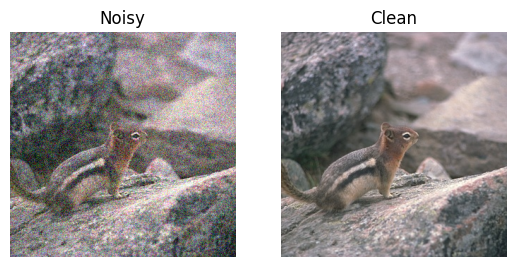

In [21]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], axes[1])
axes[1].set_title('Clean')
print(f"Image size is {x[0].shape}")

# Base class, loss function implemented

In [22]:
# class NNRegressor(nt.NeuralNetwork):

#     def __init__(self):
#         super(NNRegressor, self).__init__()
#         self.mse = nn.MSELoss()
    
#     def criterion(self, y, d):
#         return self.mse(y, d)

### Pytorch instead of nntools

In [23]:

class NNRegressor(nn.Module):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
    
    def criterion(self, y, d):
        return self.mse(y, d)


# DnCNN class with nntools implementation (without weight initialization)
## Model definition(?)
### Variable 'D' represents depth of the work i.e. the number of hidden layers
### Variable 'C' represents the number of channels in a layer of the network. 
#### 1. Channels refer to the different feature dimensions present in the data passed between layers. 
#### 2. This model's first layer maps the information the three input channels -- namely, red, green, and blue channels -- to a C=64 channel feature map. 
#### 3. It then has maps these 64 features to another 64 features along the D hidden layers of the network.
#### 4. Finally, it encodes those final 64 features back to the original 3 channels which we began with. 
## Forward pass
#### 1. Applies the first convolution and ReLU
#### 2. Repeat D blocks of: Convolution -> BatchNorm -> ReLU
#### 3. Applies a final convolution to get the residual
#### 4. Adds the input x to the output for a skip connection


In [24]:
# class DnCNN(NNRegressor):

#     def __init__(self, D, C=64):
#         super(DnCNN, self).__init__()
#         self.D = D
        
#         self.conv = nn.ModuleList()
#         self.conv.append(nn.Conv2d(3, C, 3, padding=1))
#         self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
#         self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
#         self.bn = nn.ModuleList()
#         for k in range(D):
#             self.bn.append(nn.BatchNorm2d(C, C))

#     def forward(self, x):
#         D = self.D
#         h = F.relu(self.conv[0](x))
#         for i in range(D):
#             h = F.relu(self.bn[i](self.conv[i+1](h)))
#         y = self.conv[D+1](h) + x
#         return y
                  

### Pytorch instead of nntools(without weight intialization(explain weight initialization))

In [25]:
class DnCNN(NNRegressor):
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        layers = [nn.Conv2d(in_channels=3, out_channels=C, kernel_size=3, padding=1)]

        for _ in range(D):
            layers.append(nn.Conv2d(in_channels=C, out_channels=C, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(C, C)) # Try with just one argument, similar to the behavior with weight initialization(at least visually)
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(in_channels=C, out_channels=3, kernel_size=3, padding=1))

        self.dncnn = nn.Sequential(*layers) ##EXPLAIN IN MARKDOWN

    def forward(self, x):
        residual = self.dncnn(x)
        return x + residual # EXPLAIN IN MARKDOWN


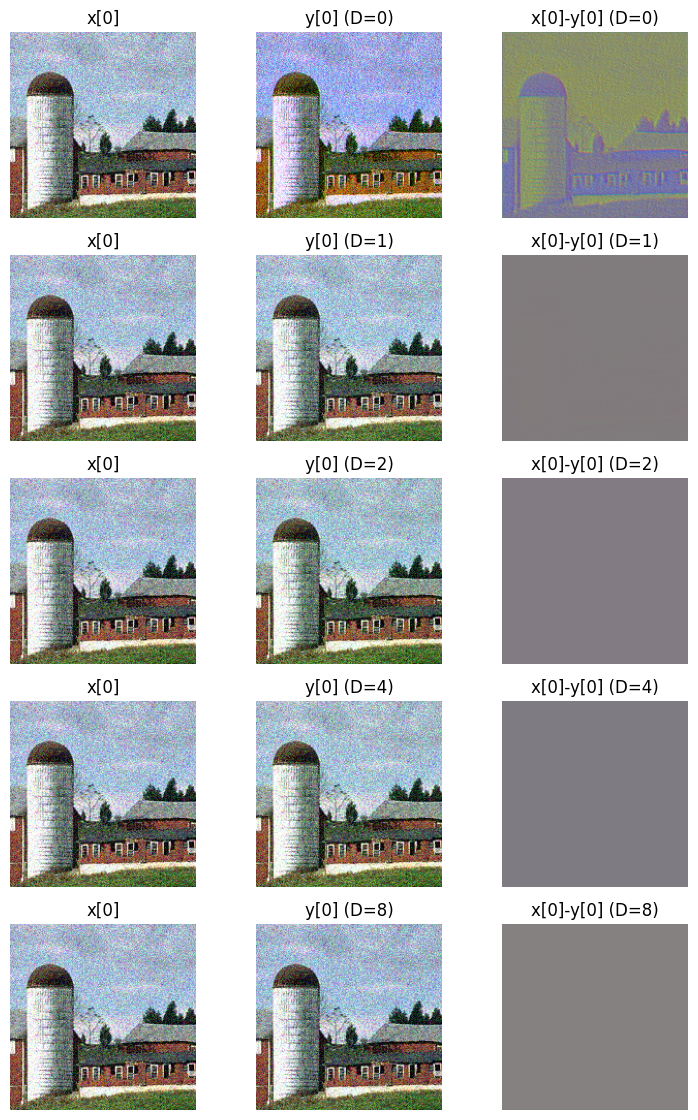

In [26]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds),ncols=3, figsize=(9, 14))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)

    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f"y[0] (D={Ds[i]})")
    myimshow(x[0] - y[0], ax=axes[i][2])
    axes[i][2].set_title(f"x[0]-y[0] (D={Ds[i]})")

### Explain above figure

# DnCNN with weight initialization

In [27]:
class DnCNN(NNRegressor):
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D

        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))

        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight, nonlinearity='relu')

        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])

        for i in range(len(self.bn)):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

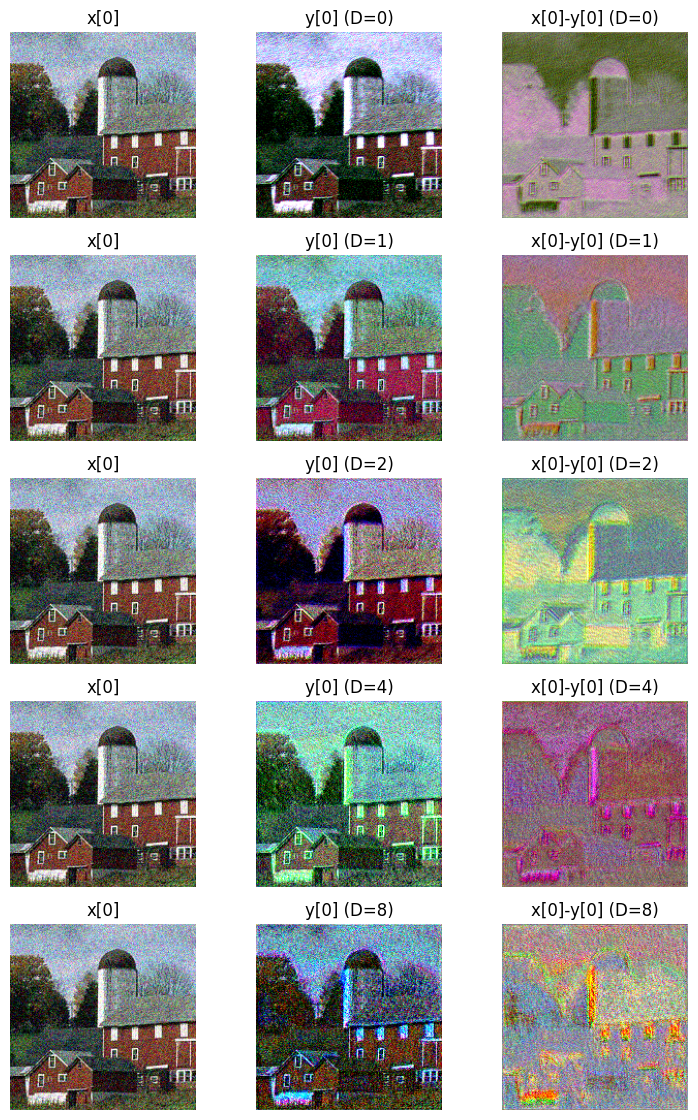

In [28]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds),ncols=3, figsize=(9, 14))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)

    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f"y[0] (D={Ds[i]})")
    myimshow(x[0] - y[0], ax=axes[i][2])
    axes[i][2].set_title(f"x[0]-y[0] (D={Ds[i]})")

### Explain above figure

In [29]:
from torchmetrics.functional import structural_similarity_index_measure as ssim

class DenoisingStatsManager:
    def __init__(self):
        self.init()

    def init(self):
        self.total_loss = 0.0
        self.running_psnr = 0.0
        self.running_ssim = 0.0
        self.running_update = 0
    
    def accumulate(self, loss, x, y, d):
        self.total_loss += loss.item()
        self.running_update += 1

        #PSNR
        n = x.numel()
        mse = torch.norm(y - d).pow(2) / n
        psnr = 10 * torch.log10(4 / mse)
        self.running_psnr += psnr.item()

        #SSIM
        y_clamped = (y + 1) / 2
        d_clamped = (d + 1) / 2

        self.running_ssim += ssim(y_clamped, d_clamped, data_range=1.0).item()

    def summarize(self):
        avg_loss = self.total_loss / self.running_update
        avg_psnr = self.running_psnr / self.running_update
        avg_ssim = self.running_ssim / self.running_update
        return {
            'loss': avg_loss,
            'PSNR': avg_psnr,
            'SSIM': avg_ssim
        }


In [30]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    
    # with torch.no_grad():
    #     denoised = exp.net(noisy[None].to(net.device))[0]
    
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy')

    #myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised')

    axes[1][0].plot([exp.history[k][0] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()
    

## train the DnCNN

In [31]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, stats_manager,
                num_epochs=10, device='cuda', output_dir='./checkpoints'):
    
    os.makedirs(output_dir, exist_ok=True)
    model.to(device)

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        stats_manager.init()
        print(f"\nEpoch {epoch+1}/{num_epochs} — Training")
        train_bar = tqdm(train_loader, desc="Train", leave=False)

        for x, d in train_bar:
            x, d = x.to(device), d.to(device)
            y = model(x)
            loss = model.criterion(y, d)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            stats_manager.accumulate(loss, x, y, d)

            train_bar.set_postfix(loss=loss.item())

        train_stats = stats_manager.summarize()
        print(f"[Epoch {epoch+1}] Training  — Loss: {train_stats['loss']:.4f}, "
              f"PSNR: {train_stats['PSNR']:.2f}, SSIM: {train_stats['SSIM']:.4f}")

        # --- Validation ---
        if val_loader is not None:
            model.eval()
            stats_manager.init()
            print(f"Epoch {epoch+1}/{num_epochs} — Validation")
            val_bar = tqdm(val_loader, desc="Val", leave=False)

            with torch.no_grad():
                for x, d in val_bar:
                    x, d = x.to(device), d.to(device)
                    y = model(x)
                    loss = model.criterion(y, d)
                    stats_manager.accumulate(loss, x, y, d)

                    val_bar.set_postfix(loss=loss.item())

            val_stats = stats_manager.summarize()
            print(f"[Epoch {epoch+1}] Validation — Loss: {val_stats['loss']:.4f}, "
                  f"PSNR: {val_stats['PSNR']:.2f}, SSIM: {val_stats['SSIM']:.4f}")
        
        # --- Checkpoint ---
        ckpt_path = os.path.join(output_dir, f"model_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), ckpt_path)


In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=4,shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)


learning_rate = 1e-3
model = DnCNN(6)
adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
stats_manager = DenoisingStatsManager()
train_model(model, train_loader, test_loader, adam, stats_manager, num_epochs=10, device=device, output_dir='/results/first_run')


Epoch 1/10 — Training


Train:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\13463\AppData\Roaming\Python\Python39\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


[Epoch 1] Training  — Loss: 0.0559, PSNR: 19.10, SSIM: 0.3386
Epoch 1/10 — Validation


[Epoch 1] Validation — Loss: 0.0300, PSNR: 21.26, SSIM: 0.4157

Epoch 2/10 — Training


[Epoch 2] Training  — Loss: 0.0259, PSNR: 21.91, SSIM: 0.4502
Epoch 2/10 — Validation


[Epoch 2] Validation — Loss: 0.0225, PSNR: 22.49, SSIM: 0.4685

Epoch 3/10 — Training


[Epoch 3] Training  — Loss: 0.0210, PSNR: 22.81, SSIM: 0.4810
Epoch 3/10 — Validation


[Epoch 3] Validation — Loss: 0.0191, PSNR: 23.21, SSIM: 0.4985

Epoch 4/10 — Training


[Epoch 4] Training  — Loss: 0.0183, PSNR: 23.40, SSIM: 0.5058
Epoch 4/10 — Validation


[Epoch 4] Validation — Loss: 0.0169, PSNR: 23.74, SSIM: 0.5251

Epoch 5/10 — Training


[Epoch 5] Training  — Loss: 0.0162, PSNR: 23.95, SSIM: 0.5234
Epoch 5/10 — Validation


[Epoch 5] Validation — Loss: 0.0152, PSNR: 24.21, SSIM: 0.5441

Epoch 6/10 — Training


[Epoch 6] Training  — Loss: 0.0148, PSNR: 24.34, SSIM: 0.5493
Epoch 6/10 — Validation


[Epoch 6] Validation — Loss: 0.0139, PSNR: 24.60, SSIM: 0.5632

Epoch 7/10 — Training


[Epoch 7] Training  — Loss: 0.0136, PSNR: 24.70, SSIM: 0.5675
Epoch 7/10 — Validation


[Epoch 7] Validation — Loss: 0.0128, PSNR: 24.94, SSIM: 0.5745

Epoch 8/10 — Training


[Epoch 8] Training  — Loss: 0.0127, PSNR: 24.98, SSIM: 0.5812
Epoch 8/10 — Validation


[Epoch 8] Validation — Loss: 0.0122, PSNR: 25.18, SSIM: 0.5890

Epoch 9/10 — Training


[Epoch 9] Training  — Loss: 0.0118, PSNR: 25.30, SSIM: 0.5928
Epoch 9/10 — Validation


[Epoch 9] Validation — Loss: 0.0114, PSNR: 25.48, SSIM: 0.6072

Epoch 10/10 — Training


[Epoch 10] Training  — Loss: 0.0113, PSNR: 25.51, SSIM: 0.6066
Epoch 10/10 — Validation


[Epoch 10] Validation — Loss: 0.0109, PSNR: 25.68, SSIM: 0.6169


### Let's see how well it performs on a test with this little bit of training

In [36]:
import os

model_path =  os.path.join("/results/first_run", f"model_epoch10.pth")
if os.path.exists(model_path):
    print("Underneath the bridge")
    print("Don't call it a fight, if it's really a war")

else:
    print("Top has sprung a leak")


Underneath the bridge
Don't call it a fight, if it's really a war


In [37]:
model.load_state_dict(torch.load(model_path))
model.eval()

DnCNN(
  (mse): MSELoss()
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1-6): 6 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn): ModuleList(
    (0-5): 6 x BatchNorm2d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
def add_noise_to_image(image, noise_type="gaussian", intensity=25):
    if noise_type == "gaussian":
        row, col, ch = image.shape


In [ ]:
def load_images(img_dir_path, image_size=(180, 180)):
    files = os.listdir(img_dir_path)
    for i in len(files):
        clean_images = []
        noisy_images = []
        img_path = os.path.join(img_dir_path, files[i])
        clean = Image.open(img_path).convert('RGB')

        i = np.random.randint(clean.size[0] - image_size[0])
        j = np.random.randint(clean.size[1] - image_size[1])

        clean = clean.crop([i, j, i + image_size[0], j + image_size[1]])
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
        clean = transform(clean)
        clean_images.append(clean)
